## 1. Too cute to pass up
<p>While I was practicing on DataCamp, I saw they had a mini project up that did A/B testing on an adorable game called Cookie Cats, and I couldn't pass it up. Apparently the game is a popular mobile puzzle game in the "connect three"-style. The player connects tiles and clears the board to win the level.
<p>Players will encounter gates that force them to wait a non-trivial amount of time or make an in-app purchase to progress. In addition to driving in-app purchases, these gates serve the important purpose of giving players an enforced break from playing the game, hopefully resulting in the player's enjoyment of the game being increased and prolonged.</p>
<p>Initially the first gate was placed at level 30, but DataCamp provides a dataset to analyze an AB-test where the first gate in Cookie Cats is moved from level 30 to level 40. The question is, how does this impact player retention?</p>
<p>The project uses bootstrap analysis to inform a conclusion, rather than formal hypothesis testing. However, for a small project, it's great!</p>

<p>As always, we have to do EDA before anything else:</p>

In [20]:
# Importing pandas
import pandas as pd

# Reading in the data
df = pd.read_csv('datasets/cookie_cats.csv')

# Showing the first few rows
display(df.head())

# Getting shape and info
display(df.shape)

display(df.info())

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


(90189, 5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
userid            90189 non-null int64
version           90189 non-null object
sum_gamerounds    90189 non-null int64
retention_1       90189 non-null bool
retention_7       90189 non-null bool
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


None

## 2. The AB-test data
<p>The data is from 90,189 players that installed the game while the AB-test was running. The variables are:</p>
<ul>
<li><code>userid</code> - a unique number that identifies each player.</li>
<li><code>version</code> - whether the player was put in the control group (<code>gate_30</code> - a gate at level 30) or the group with the moved gate (<code>gate_40</code> - a gate at level 40).</li>
<li><code>sum_gamerounds</code> - the number of game rounds played by the player during the first 14 days after install.</li>
<li><code>retention_1</code> - did the player come back and play <strong>1 day</strong> after installing?</li>
<li><code>retention_7</code> - did the player come back and play <strong>7 days</strong> after installing?</li>
</ul>
<p>When a player installed the game, he or she was randomly assigned to either <code>gate_30</code> or <code>gate_40</code>. We can verify that the sizes of the two groups are roughly equal.</p>

In [21]:
# Counting the number of players in each AB group.
df.groupby(by="version").count()

,userid,sum_gamerounds,retention_1,retention_7
version,,,,
gate_30,44700,44700,44700,44700
gate_40,45489,45489,45489,45489


## 3. The distribution of game rounds
<p>The two group sizes are roughly the same, which is good.</p>
<p>What we want to analyze is how the gate placement affects player retention. Before we do that, it helps to have some visuals to get a sense of what the data has to show. The following is a plot of the distribution of the number of game rounds players played during their first week playing the game.</p>

Text(0, 0.5, 'Count')

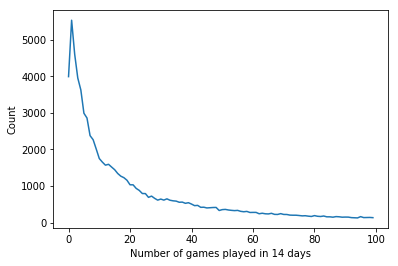

In [22]:
%matplotlib inline

# Counting the number of players for each number of gamerounds 
plot_df = df.groupby(by="sum_gamerounds")['userid'].count()

# Plotting the distribution of players that played 0 to 100 game rounds
ax = plot_df.head(100).plot(x='sum_gamerounds', y='userid')
ax.set_xlabel("Number of games played in 14 days")
ax.set_ylabel("Count")

## 4. Overall 1-day retention
<p>The plot shows that some players install the game but then never play it (0 game rounds), some players just play a couple of game rounds in their first week, and some may have gone overboard.</p>
<p>The goal of the game creators is to get players hooked. A metric in the video gaming industry for how fun and engaging a game is <em>1-day retention</em>: The percentage of players that comes back and plays the game <em>one day</em> after they have installed it.  The higher 1-day retention is, the easier it is to retain players and build a large player base. </p>
<p>Let's look at what 1-day retention is overall.</p>

In [23]:
# The % of users that came back the day after they installed
df['retention_1'].mean()

0.4452095044850259

## 5. 1-day retention by AB-group

<p>A little less than half of the players come back one day after installing the game. Now let's look at how 1-day retention differs between the two AB-groups.</p>

In [24]:
# Calculating 1-day retention for each AB-group
df.groupby(by="version")['retention_1'].mean()

version
gate_30    0.448188
gate_40    0.442283
Name: retention_1, dtype: float64

## 6. How different are the two groups?
<p>There was a slight decrease in 1-day retention when the gate was moved to level 40 (44.2%) compared to the control when it was at level 30 (44.8%). It's a small change, but how certain are we that a gate at level 40 is worse?</p>
<p>Bootstrapping can help us here. We will repeatedly re-sample our dataset (with replacement) and calculate 1-day retention for those samples. The variation in 1-day retention will give us an indication of how uncertain the retention numbers are.</p>

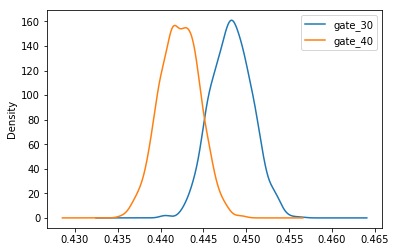

In [25]:
# Creating an list with bootstrapped means for each AB-group
boot_1d = []
for i in range(1000):
    boot_mean = df.sample(replace=True, frac=1).groupby(by="version")["retention_1"].mean()
    boot_1d.append(boot_mean)
 
# Transforming the list to a DataFrame
boot_1d = pd.DataFrame(data=boot_1d, columns=["gate_30", "gate_40"])
    
# A Kernel Density Estimate plot of the bootstrap distributions
boot_1d.plot.kde()

## 7. Looking at the differences
<p>The two distributions above represent the bootstrap uncertainty over what the underlying 1-day retention could be for the two AB-groups. We can see that there seems to be some evidence of a difference, albeit small. Let's look closer at the difference in 1-day retention</p>

Text(0.5, 0, 'Percent difference in 1-day retention')

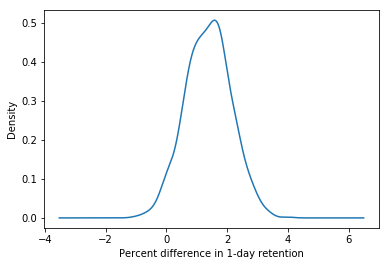

In [26]:
# Adding a column with the % difference between the two AB-groups
boot_1d['diff'] = (boot_1d["gate_30"]-boot_1d["gate_40"])/boot_1d["gate_40"] *100

# Plotting the bootstrap % difference
ax = boot_1d["diff"].plot.kde()
ax.set_xlabel("Percent difference in 1-day retention")

## 8. The probability of a difference

<p>We can visually see that the most likely % difference is around 1% - 2%, and that most of the distribution is above 0%, in favor of a gate at level 30. But what is the <em>probability</em> that the difference is above 0%? Let's calculate that as well.</p>

In [27]:
# Calculating the probability that 1-day retention is greater when the gate is at level 30
prob = (boot_1d['diff']>0).mean()

# Printing the probability
f'{prob:.2%}'

'96.80%'

## 9. 7-day retention by AB-group
<p>The bootstrap analysis shows that there is a high probability that 1-day retention is better when the gate is at level 30. However, since players have only been playing the game for one day, it is likely that most players haven't reached level 30 yet. That is, many players won't have been affected by the gate, even if it's as early as level 30. </p>
<p>But after having played for a week, more players should have reached level 40, and therefore it makes sense to also look at 7-day retention. That is: What percentage of the people that installed the game also showed up a week later to play the game again.</p>
<p>Let's start by calculating 7-day retention for the two AB-groups.</p>

In [28]:
# Calculating 7-day retention for both AB-groups
df.groupby(by="version")['retention_7'].mean()

version
gate_30    0.190201
gate_40    0.182000
Name: retention_7, dtype: float64

## 10. Bootstrapping the difference again
<p>Like with 1-day retention, we see that 7-day retention is slightly lower (18.2%) when the gate is at level 40 than when the gate is at level 30 (19.0%). This difference is also larger than for 1-day retention, presumably because more players have had time to hit the first gate. We also see that the <em>overall</em> 7-day retention is lower than the <em>overall</em> 1-day retention; fewer people play a game a week after installing than a day after installing.</p>
<p>Again, let's use bootstrap analysis to figure out how certain we should be of the difference between the AB-groups.</p>

'100.00%'

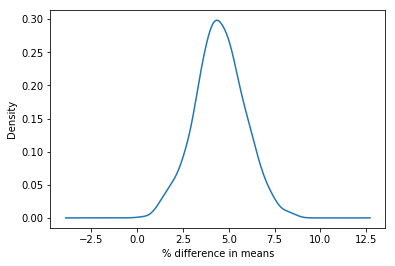

In [30]:
# Creating a list with bootstrapped means for each AB-group
boot_7d = []
for i in range(1000):
    boot_mean = df.sample(replace=True, frac=1).groupby(by="version")["retention_7"].mean()
    boot_7d.append(boot_mean)

# Transforming the list to a DataFrame
boot_7d = pd.DataFrame(data=boot_7d, columns=["gate_30", "gate_40"])

# Adding a column with the % difference between the two AB-groups
boot_7d['diff'] = (boot_7d["gate_30"]-boot_7d["gate_40"])/boot_7d["gate_40"] *100

# Plotting the bootstrap % difference
ax = boot_7d["diff"].plot.kde()
ax.set_xlabel("% difference in means")

# Calculating the probability that 7-day retention is greater when the gate is at level 30
prob = (boot_7d['diff']>0).mean()

# Printing the probability
f'{prob:.2%}'

## 11.  Conclusion
<p>The bootstrap result shows strong evidence that 7-day retention is higher when the gate is at level 30 than when it is at level 40. The conclusion is: to keep retention high — both 1-day and 7-day retention — do <strong>not</strong> move the gate from level 30 to level 40.</p>